In [1]:
import os
import random

# ─── CONFIG ────────────────────────────────────────────────────────────────────
src_dir = "holdout_data"      # your folder
keep_fraction = 0.05          # fraction of positives to keep
random_seed = 42              # for reproducibility
# ────────────────────────────────────────────────────────────────────────────────

random.seed(random_seed)

# 1. List all .dat files and extract unique stems
all_files = os.listdir(src_dir)
dat_files = [f for f in all_files if f.endswith(".dat")]
stems = {os.path.splitext(f)[0] for f in dat_files}

# 2. Split into negative vs positive stems
neg_stems = [s for s in stems if s.startswith("00")]
pos_stems = [s for s in stems if not s.startswith("00")]

# 3. Sample 5% of positives
n_keep = max(1, int(len(pos_stems) * keep_fraction))
keep_pos = set(random.sample(pos_stems, n_keep))

# 4. Build the final keep‐set
keep = set(neg_stems) | keep_pos

# 5. Delete all other positive records
for stem in stems:
    if stem not in keep:
        for ext in (".dat", ".hea"):
            path = os.path.join(src_dir, stem + ext)
            if os.path.exists(path):
                os.remove(path)
        print(f"Removed {stem} (both .dat/.hea)")

print("Done. Kept", len(neg_stems), "negatives +", len(keep_pos), "positives.")


Removed 111288 (both .dat/.hea)
Removed 88506 (both .dat/.hea)
Removed 101842 (both .dat/.hea)
Removed 99398 (both .dat/.hea)
Removed 28877 (both .dat/.hea)
Removed 117986 (both .dat/.hea)
Removed 181736 (both .dat/.hea)
Removed 149836 (both .dat/.hea)
Removed 56422 (both .dat/.hea)
Removed 185588 (both .dat/.hea)
Removed 24756 (both .dat/.hea)
Removed 177005 (both .dat/.hea)
Removed 175346 (both .dat/.hea)
Removed 201711 (both .dat/.hea)
Removed 146494 (both .dat/.hea)
Removed 162030 (both .dat/.hea)
Removed 135830 (both .dat/.hea)
Removed 134793 (both .dat/.hea)
Removed 60948 (both .dat/.hea)
Removed 204537 (both .dat/.hea)
Removed 121673 (both .dat/.hea)
Removed 169272 (both .dat/.hea)
Removed 134634 (both .dat/.hea)
Removed 43580 (both .dat/.hea)
Removed 199873 (both .dat/.hea)
Removed 50222 (both .dat/.hea)
Removed 24028 (both .dat/.hea)
Removed 179724 (both .dat/.hea)
Removed 199009 (both .dat/.hea)
Removed 184107 (both .dat/.hea)
Removed 164072 (both .dat/.hea)
Removed 94527 (bo


Confusion Matrix:
              Pred False  Pred True
Actual False         163          9
Actual True            6          2


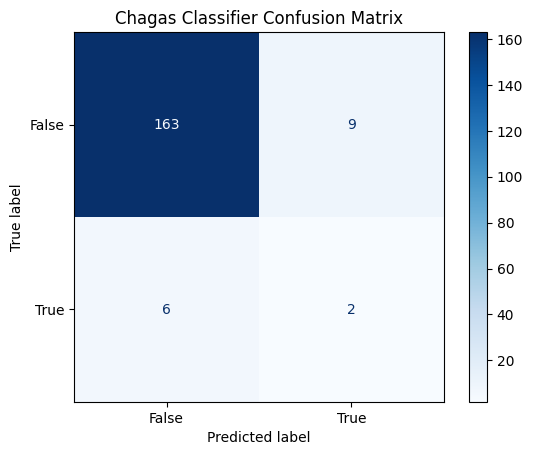

In [4]:
import os
import re
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ─── CONFIG ────────────────────────────────────────────────────────────────────
pred_folder = "holdout_outputs"  # your .txt predictions
data_folder = "holdout_data"     # your .hea ground truth
threshold   = 0.5                # probability cutoff for positive
# ────────────────────────────────────────────────────────────────────────────────

# Regexes
pat_pred_prob  = re.compile(r"Chagas probability:\s*([0-9.eE+-]+)")
pat_true_label = re.compile(r"# Chagas label:\s*(True|False)")

# 1) Load predictions
preds = {}
for fn in os.listdir(pred_folder):
    if not fn.endswith(".txt"): continue
    stem = os.path.splitext(fn)[0]
    text = open(os.path.join(pred_folder, fn)).read()
    m = pat_pred_prob.search(text)
    if not m:
        raise ValueError(f"No probability found in {fn}")
    prob = float(m.group(1))
    preds[stem] = (prob >= threshold)

# 2) Load true labels
trues = {}
for fn in os.listdir(data_folder):
    if not fn.endswith(".hea"): continue
    stem = os.path.splitext(fn)[0]
    text = open(os.path.join(data_folder, fn)).read()
    m = pat_true_label.search(text)
    if not m:
        raise ValueError(f"No true‐label in {fn}")
    trues[stem] = (m.group(1) == "True")

# 3) Build DataFrame of only those stems present in both
records = []
for stem, y_true in trues.items():
    if stem not in preds:
        # either warn or skip
        print(f"Warning: no prediction for {stem}, skipping")
        continue
    y_pred = preds[stem]
    records.append({"stem": stem, "true": y_true, "pred": y_pred})

df = pd.DataFrame(records)

# 4) Compute confusion matrix
cm = confusion_matrix(df["true"], df["pred"], labels=[False, True])
cm_df = pd.DataFrame(cm,
                     index=["Actual False","Actual True"],
                     columns=["Pred False","Pred True"])

print("\nConfusion Matrix:")
print(cm_df)

# Optional: plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["False","True"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Chagas Classifier Confusion Matrix")
plt.show()
